# Load trained model parameters on new abstracts.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/elsevier/Bert-NER-V2'
%cd $path
import random
import utils_train as ut
import net
from transformers import BertForMaskedLM, BertTokenizer
import torch
!pip install highlight-text
import matplotlib.pyplot as plt
from highlight_text import HighlightText
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/elsevier/Bert-NER-V2


In [9]:
example = 'Advances in machine learned interatomic potentials (MLIPs), such as those using neural networks, have resulted in short-range models that can infer interaction energies with near ab initio accuracy and orders of magnitude reduced computational cost. For many atom systems, including macromolecules, biomolecules, and condensed matter, model accuracy can become reliant on the description of short- and long-range physical interactions. The latter terms can be difficult to incorporate into an MLIP framework. Recent research has produced numerous models with considerations for nonlocal electrostatic and dispersion interactions, leading to a large range of applications that can be addressed using MLIPs. In light of this, we present a Perspective focused on key methodologies and models being used where the presence of nonlocal physics and chemistry are crucial for describing system properties. The strategies covered include MLIPs augmented with dispersion corrections, electrostatics calculated with charges predicted from atomic environment descriptors, the use of self-consistency and message passing iterations to propagated nonlocal system information, and charges obtained via equilibration schemes. We aim to provide a pointed discussion to support the development of machine learning-based interatomic potentials for systems where contributions from only nearsighted terms are deficient.'

## Load parameters

In [2]:
CLASSES = {'MATERIAL': 1, 'MLIP': 2, 'PROPERTY': 3,
           'VALUE': 4, 'APPLICATION': 5, 'O': 0}
SEED = 32
MAX_LENGTH = 512
ut.seed_everything(SEED)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=MAX_LENGTH)
model = net.NERBERTModel(modelBERT.base_model, output_size=len(CLASSES)+1)
parameter_path = path + '/saved_models/test_model.pt'
model.load_state_dict(torch.load(parameter_path))
model.eval()
print('Model loaded')

Model loaded


## Feed text to model

In [10]:
def inference(text_test, tokenizer, max_length):
    text_list = ut.split_para(text_test)
    token_list = tokenizer.convert_tokens_to_ids(text_list)
    data_test = torch.tensor(token_list + [0] * (max_length - len(token_list)))[None, :]
    att_mask_test = torch.tensor([1] * len(text_list) + [0] * (max_length - len(text_list)))[None, :]
    y_pred_test = model(data_test, attention_mask=att_mask_test)
    y_pred_test = torch.swapaxes(y_pred_test, 1, 2)
    pred = y_pred_test.max(dim=1)[1][0][:len(text_list)]
    return pred, text_list
pred, text_list = inference(example, tokenizerBERT, MAX_LENGTH)

# Show prediction

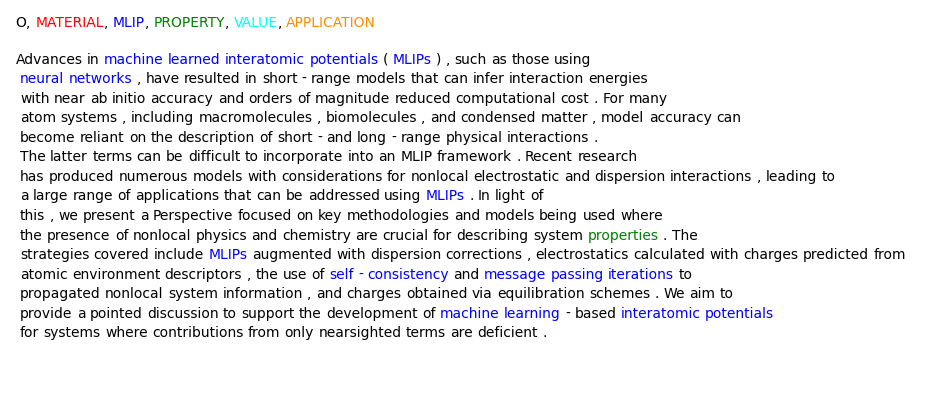

In [11]:
colors = ['black', 'red', 'blue', 'green', 'cyan', 'darkorange']
word_list_marked = ['<' + w + '>' for w in text_list]
markers = [{"color": colors[i]} for i in pred]
j = 0
for i in range(len(text_list)):
    if (i + 1) % 15 == 0:
        word_list_marked.insert(i + j, '\n')
        j += 1
fig, ax = plt.subplots()
ax.set_axis_off()
HighlightText(x=0., y=1, s='<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <VALUE>, <APPLICATION>',
              highlight_textprops=[{"color": c} for c in colors], ax=ax)
HighlightText(x=0., y=0.9, s=' '.join(word_list_marked),
              highlight_textprops=markers, ax=ax)
plt.show()